In [13]:
import numpy as np
import seaborn as sns
import pandas as pd
import re
import os
from cmdstanpy import cmdstan_path, CmdStanModel
import matplotlib.pyplot as plt
import scipy as sci
import stan_helpers as sh

# Processing data from AMW/5HTP experiments

In [14]:
ser_drugs=pd.read_csv("serotonin_drug-longform.csv")
serotonin_mutants=pd.read_csv("serotonin_mutant_longform.csv")
serotonin_mutants["Batch #"]=serotonin_mutants["Batch #"]+3
serall=pd.concat([serotonin_mutants,ser_drugs])


In [15]:

ser_drugs[ser_drugs["Day"].isin([1])].groupby("Drug Treatment").count()


,Unnamed: 0,Batch #,Fly ID,Date,Day,nTurns,rBias
Drug Treatment,,,,,,,
5-HTP,192,192,192,192,192,192,173
Control,192,192,192,192,192,192,186
aMW,192,192,192,192,192,192,184


In [16]:
ser_drugs.groupby("Drug Treatment").count()

,Unnamed: 0,Batch #,Fly ID,Date,Day,nTurns,rBias
Drug Treatment,,,,,,,
5-HTP,1728,1728,1728,1728,1728,1727,826
Control,1728,1728,1728,1728,1728,1728,1287
aMW,1728,1728,1728,1728,1728,1728,1111


In [17]:
serotonin_mutants["Drug Treatment"]=pd.Categorical(serotonin_mutants["Drug Treatment"])
serotonin_mutants

,Unnamed: 0,Batch #,Fly ID,Date,Day,Drug Treatment,nTurns,rBias
0,0,4,1,5/4,1,TrH,466,0.526882
1,1,4,2,5/4,1,TrH,500,0.442886
2,2,4,3,5/4,1,TrH,567,0.556537
3,3,4,4,5/4,1,TrH,526,0.565714
4,4,4,5,5/4,1,TrH,370,0.696477
...,...,...,...,...,...,...,...,...
1723,1723,4,92,5/20,17,control,-1,NaN
1724,1724,4,93,5/20,17,control,-1,NaN
1725,1725,4,94,5/20,17,control,-1,NaN
1726,1726,4,95,5/20,17,control,-1,NaN


In [18]:
serotonin_mutants[serotonin_mutants["Day"].isin([1])].groupby("Drug Treatment").count()


,Unnamed: 0,Batch #,Fly ID,Date,Day,nTurns,rBias
Drug Treatment,,,,,,,
TrH,96,96,96,96,96,96,93
control,96,96,96,96,96,96,94


In [19]:
# serall=pd.concat([serotonin_mutants,ser_drugs])
serall["Drug Treatment"]=pd.Categorical(serall["Drug Treatment"])
serall

,Unnamed: 0,Batch #,Fly ID,Date,Day,Drug Treatment,nTurns,rBias
0,0,4,1,5/4,1,TrH,466.0,0.526882
1,1,4,2,5/4,1,TrH,500.0,0.442886
2,2,4,3,5/4,1,TrH,567.0,0.556537
3,3,4,4,5/4,1,TrH,526.0,0.565714
4,4,4,5,5/4,1,TrH,370.0,0.696477
...,...,...,...,...,...,...,...,...
5179,5179,3,92,2/22,17,aMW,-1.0,NaN
5180,5180,3,93,2/22,17,aMW,-1.0,NaN
5181,5181,3,94,2/22,17,aMW,222.0,0.271493
5182,5182,3,95,2/22,17,aMW,-1.0,NaN


In [20]:
ser_drugs["uID"]=pd.Categorical("F"+pd.Series(ser_drugs["Fly ID"], dtype=str)+"B"+pd.Series(ser_drugs["Batch #"], dtype=str) + "C" + pd.Series(ser_drugs["Drug Treatment"], dtype=str)).codes
ser_drugs["uID"].unique().shape

(576,)

In [21]:
serotonin_mutants["uID"]=pd.Categorical("F"+pd.Series(serotonin_mutants["Fly ID"], dtype=str)+"B"+pd.Series(serotonin_mutants["Batch #"], dtype=str) + "C" + pd.Series(serotonin_mutants["Drug Treatment"], dtype=str)).codes
serotonin_mutants["uID"].unique().shape

(192,)

In [22]:
serall["uID"]=pd.Categorical("F"+pd.Series(serall["Fly ID"], dtype=str)+"B"+pd.Series(serall["Batch #"], dtype=str) + "C" + pd.Series(serall["Drug Treatment"], dtype=str)).codes
serall["uID"].unique().shape

(768,)

In [23]:
def return_stan_dict(serall):
  #This function does the necessary processing to prepare a dictionary for STAN
  # serall["uID"]=pd.Categorical("F"+pd.Series(serall["Fly ID"], dtype=str)+"B"+pd.Series(serall["Batch #"], dtype=str) + "C" + pd.Series(serall["Drug Treatment"], dtype=str)).codes
  # len(serall["uID"].unique())
  serall["x"]=np.array(((serall["nTurns"]+1)*serall["rBias"]), dtype=int)
  # serall.dropna()
  serall_obs=serall.dropna()
  serall_obs=serall_obs[serall_obs["nTurns"]>0]
  # serall_obs
  serall_mis=serall.drop(serall_obs.index)
  # serall_mis
  posnturns=serall[serall["nTurns"]>0]
  posnturns[posnturns.isna().any(axis=1)]
  serna=serall[serall.isna().any(axis=1)]
  serna[serna["nTurns"]>0]
  serall[serall["nTurns"]>0].isna().any(axis=1)
  #select from serall all rows where rBias is Nan or nTurns is less than 1
  serna=serall[serall.isna().any(axis=1)]
  serna=serna[serna["nTurns"]<0]
  # serna

  serall[serall["nTurns"]>0]
  serall[serall["nTurns"]<1].dropna()
  # serall_mis=serall[serall.isna().any(axis=1)]
  # # serall_mis=serall[serall[serall["nTurns"]>0].isna().any(axis=1)]
  # serall_mis=pd.concat(serall_mis, serall[serall["nTurns"]<1])
  # np.array(np.nan, dtype=int)
  # skt_unmelted_mis_b=skt_unmelted_mis
  dummyrow=serall_mis.iloc[0,:]
  # dummyrow
  actualdays=np.unique(serall_mis["Day"])
  fullrange=np.arange(0,np.max(actualdays), dtype=float)
  for ii, i in enumerate(actualdays):
    for jj, j in enumerate(fullrange):
      if j==i:
        # print(j)
        # print(i)
        fullrange[jj]=np.nan


  missingdays=np.array(pd.Series(fullrange).dropna(), dtype=int)


  # np.unique(serall_obs["Day"])
  for i in range(serall["uID"].unique().shape[0]):
    dummyrownew=dummyrow.copy()
    dummyrownew.loc['uID']=int(i)
    for j in missingdays:
      dummyrownew.loc['Day']=int(j)
      serall_mis=pd.concat([serall_mis, pd.DataFrame(dummyrownew).T])
      # skt_unmelted_mis_b.append(dummyrow)
  # serall["uID"].unique().shape[0]
  # pd.Categorical(serall["uID"]).codes.max()
  # np.array(serall["Day"], dtype=int)+1
  # serall_mis["uID"]
  # serall
  # (pd.Categorical(serall["Drug Treatment"]).codes+1).shape
  serall_u=serall.drop_duplicates(subset="uID").sort_values("uID")
  # serall_u
  # serall0=serall[serall["uID"]==0]
  # seralld1=serall[serall0["Day"]==1]
  # seralld1
  # serall[serall[serall["Day"]==1]["uID"==0]]
  # serall[serall["Day"]==1].value_counts(subset="uID")
  groups=pd.Categorical(serall_u["Drug Treatment"])
  categories=groups.categories
  codes=groups.codes+1

  # serall["uID"].unique().shape[0]
  # del dgrp_data_ser_m6
  stan_dict={
    "N": serall["uID"].unique().shape[0], # skt.shape[0], #Total number of flies
    "S": serall["Drug Treatment"].unique().shape[0], #Total number of Lines
    
    "T": int(serall["Day"].max()+1), #Total number of Days. (1 is because stan is 1 indexing).
    "s": codes, # list of line number per fly
    "fly_i_obs": serall_obs["uID"]+1, # indexes of fly number for flattened observations
    "time_i_obs": np.array(serall_obs["Day"], dtype=int)+1, # indexes of fly number for flattened observations
    "t_obs": serall_obs['nTurns'].shape[0], # total number of observed trials
    "x_obs": np.array(serall_obs['x'], dtype=int), # flattened array with number of right turns for each obs
    "n_obs": np.array(serall_obs['nTurns']+1, dtype=int), # flattened array with number of total turns for each obs
    "fly_i_mis": np.array(serall_mis["uID"], dtype=int)+1, # indexes of fly number for flattened observations
    "time_i_mis": np.array(serall_mis["Day"], dtype=int)+1, # indexes of day number for flattened observations
    "t_mis": serall_mis['nTurns'].shape[0] # total number of observed trials
    # "x_mis": np.array(skt_unmelted['x'], dtype=int), # flattened array with number of right turns for each obs
    # "n_mis": np.array(skt_unmelted['n'], dtype=int) # flattened array with number of total turns for each obs
  }
  return stan_dict, categories

In [24]:
mutant_stan_dict, mutant_categories=return_stan_dict(serotonin_mutants)
drug_stan_dict, drug_categories=return_stan_dict(ser_drugs)
all_stan_dict, drug_categories=return_stan_dict(serall)

# AMW vs Control vs 5HTP

First Set of experiments

In [25]:
drug_stan_dict

{'N': 576,
 'S': 3,
 'T': 18,
 's': array([2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2,
        1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3,
        1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3,
        2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2,
        1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3,
        1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3,
        2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2,
        1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3,
        1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3,
        2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2,
        1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3,
        1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3,
        2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2,
   

In [26]:
# # del dgrp_data_ser_m6
# dgrp_data_ser_m6={
#   "N": serall["uID"].unique().shape[0], # skt.shape[0], #Total number of flies
#   "S": serall["Drug Treatment"].unique().shape[0], #Total number of Lines
  
#   "T": int(serall["Day"].max()+1), #Total number of Days. Changed this to 2 as hack, but I forget why (1 is because stan is 1 indexing). Maybe unmelted mis is higher?
#   "s": pd.Categorical(serall_u["Drug Treatment"]).codes+1, # list of line number per fly
#   "fly_i_obs": serall_obs["uID"]+1, # indexes of fly number for flattened observations
#   "time_i_obs": np.array(serall_obs["Day"], dtype=int)+1, # indexes of fly number for flattened observations
#   "t_obs": serall_obs['nTurns'].shape[0], # total number of observed trials
#   "x_obs": np.array(serall_obs['x'], dtype=int), # flattened array with number of right turns for each obs
#   "n_obs": np.array(serall_obs['nTurns']+1, dtype=int), # flattened array with number of total turns for each obs
#   "fly_i_mis": np.array(serall_mis["uID"], dtype=int)+1, # indexes of fly number for flattened observations
#   "time_i_mis": np.array(serall_mis["Day"], dtype=int)+1, # indexes of day number for flattened observations
#   "t_mis": serall_mis['nTurns'].shape[0] # total number of observed trials
#   # "x_mis": np.array(skt_unmelted['x'], dtype=int), # flattened array with number of right turns for each obs
#   # "n_mis": np.array(skt_unmelted['n'], dtype=int) # flattened array with number of total turns for each obs
# }


In [27]:
modelname="dmodel6_AR_transformed"
# modelname="dmodel6_AR_singlephi"
if os.path.exists(modelname):
  os.remove(modelname)

stan_file=modelname+".stan"
# stan_file="dgrp_model_test.stan"
model3 = CmdStanModel(stan_file=stan_file)


14:59:24 - cmdstanpy - INFO - compiling stan file /Users/ryanmaloney/Documents/GitHub/DGRP experiments/dmodel6_AR_transformed.stan to exe file /Users/ryanmaloney/Documents/GitHub/DGRP experiments/dmodel6_AR_transformed
14:59:35 - cmdstanpy - INFO - compiled model executable: /Users/ryanmaloney/Documents/GitHub/DGRP experiments/dmodel6_AR_transformed


In [28]:
fit3 = model3.sample(data=drug_stan_dict,
#  show_console=True,
#  adapt_delta=0.999,
 
  iter_sampling=2000)

15:00:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:02:20 - cmdstanpy - INFO - CmdStan done processing.
15:02:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmpnejj9hgt.stan', line 78, column 10 to column 51)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmpnejj9hgt.stan', line 78, column 10 to column 51)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmpnejj9hgt.stan', line 74, column 8 to column 34)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmpnejj9hgt.stan', line 78, column 10 to column 51)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq

In [29]:
print(fit3.diagnose())

Processing csv files: /var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_1.csv, /var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_2.csv, /var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_3.csv, /var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.28, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size sati

In [30]:
pd.Categorical(ser_drugs["Drug Treatment"]).categories

Index(['5-HTP', 'Control', 'aMW'], dtype='object')

In [31]:
fit3

CmdStanMCMC: model=dmodel6_AR_transformed chains=4['method=sample', 'num_samples=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_1.csv
	/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_2.csv
	/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_3.csv
	/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_4.csv
 output_files:
	/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_0-stdout.txt
	/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmpqgr80elm/dmodel6_AR_transformednd5j8tzh/dmodel6_AR_transformed-20240823150026_1-stdout.txt
	/var/fold

In [32]:
fit3.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-900183.000000,12.732300,177.039000,-900481.000000,-900181.000000,-899894.000000,193.341,0.677369,1.017500
R_obs[1],0.188468,0.000511,0.064602,0.082196,0.188236,0.294722,15974.700,55.967300,0.999746
R_obs[2],-0.175520,0.003065,0.359675,-0.769667,-0.172307,0.418824,13772.300,48.251100,0.999611
R_obs[3],-0.171503,0.000681,0.082877,-0.309322,-0.172196,-0.034108,14808.200,51.880300,0.999791
R_obs[4],-0.182912,0.001010,0.122847,-0.384754,-0.182794,0.015003,14782.300,51.789500,0.999640
...,...,...,...,...,...,...,...,...,...
"R[576,14]",0.001238,0.004870,0.515603,-0.854089,-0.001028,0.854183,11208.700,39.269600,1.000110
"R[576,15]",0.002669,0.005118,0.520080,-0.854308,0.003555,0.857687,10325.600,36.175500,1.000170
"R[576,16]",0.001180,0.005071,0.522638,-0.866672,0.008402,0.847027,10622.500,37.215900,0.999718
"R[576,17]",-0.014424,0.004878,0.505939,-0.855685,-0.007806,0.810564,10758.400,37.691900,0.999636


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,R_obs[1],R_obs[2],R_obs[3],...,"R[567,18]","R[568,18]","R[569,18]","R[570,18]","R[571,18]","R[572,18]","R[573,18]","R[574,18]","R[575,18]","R[576,18]"
0,-900015.0,0.671112,0.099003,6.0,63.0,0.0,905261.0,0.292494,-0.176935,-0.204464,...,-0.526559,0.656662,0.330105,0.781359,-0.409820,0.983802,0.665781,-0.764237,0.274051,-0.666207
1,-900035.0,0.865096,0.099003,6.0,63.0,0.0,905251.0,0.101357,-0.305011,-0.132484,...,0.760035,0.804955,-0.576434,-0.826648,0.010084,-0.357578,-0.693482,0.648639,-0.214105,0.607376
2,-899886.0,0.967989,0.099003,6.0,63.0,0.0,905107.0,0.168941,0.093950,-0.154341,...,-0.604646,0.642938,-0.144596,0.309663,-0.278206,0.198696,-0.437027,-0.050221,-0.036297,0.042354
3,-899997.0,0.657653,0.099003,6.0,63.0,0.0,905164.0,0.146428,0.254831,-0.235362,...,-1.034740,0.679983,0.286935,-0.370292,-0.221050,-0.352187,-0.345433,0.702808,0.120189,0.281367
4,-900006.0,0.744854,0.099003,6.0,63.0,0.0,905235.0,0.243665,-0.499140,-0.103118,...,1.142800,0.769855,-0.196745,0.527516,-0.246761,0.503495,0.203380,-0.572825,-0.001779,0.176972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-900209.0,0.880993,0.089656,6.0,63.0,0.0,905357.0,0.169685,-0.009634,-0.191901,...,0.055608,0.665932,-0.642155,-0.147115,-0.250557,0.305387,-0.477404,-0.264630,-0.023852,0.139704
7996,-900061.0,0.954037,0.089656,6.0,63.0,0.0,905295.0,0.214552,-0.263070,-0.136664,...,0.205434,0.805964,0.511077,-0.032622,-0.197969,-0.670131,0.340205,-0.010419,-0.329095,-0.423899
7997,-900219.0,0.784497,0.089656,6.0,63.0,0.0,905338.0,0.212499,0.547235,-0.145064,...,0.338271,0.893823,-0.182464,0.359417,-0.249909,-0.612889,-0.169880,-0.524155,-0.501857,0.039191
7998,-900115.0,0.987411,0.089656,6.0,63.0,0.0,905285.0,0.226896,0.104415,-0.195785,...,-0.118102,0.603823,-0.593058,-0.561600,-0.303646,0.808267,-0.189578,0.036885,0.066071,-0.956775


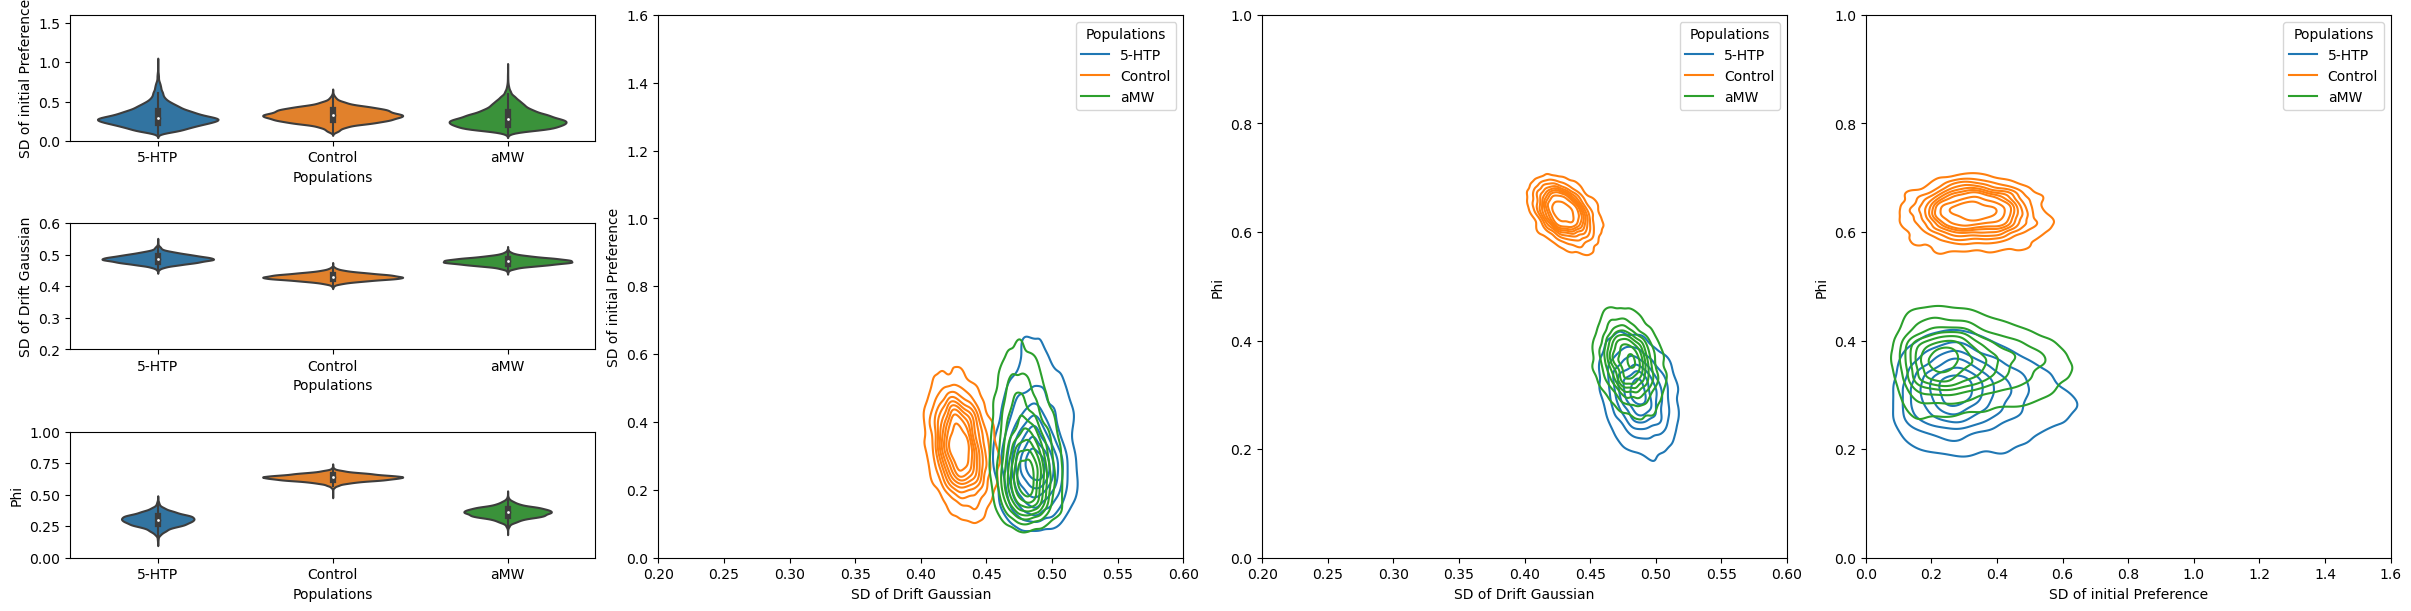

In [23]:
import importlib as imp
imp.reload(sh)
drug_fig, fd, sp = sh.plotResults(fit3, pd.Categorical(ser_drugs[
  "Drug Treatment"]).categories, var1="BH", var2="D", var3="PHI", Des1="SD of initial Preference", Des2="SD of Drift Gaussian", showallbivariateplots=True, check=False)
drug_fig.savefig("5ht_Stan_drug_fig_includingPHI.pdf", dpi=300)


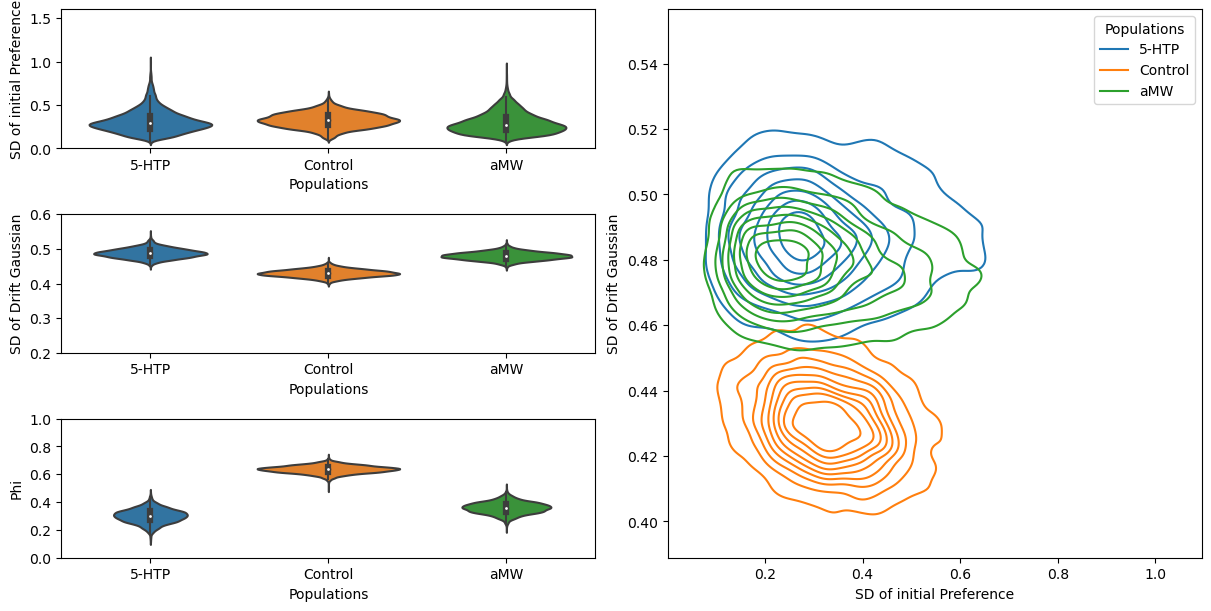

In [24]:
fig, fd, sp = sh.plotResults(fit3, pd.Categorical(ser_drugs["Drug Treatment"]).categories, var1="BH", var2="D", var3="PHI", Des1="SD of initial Preference", Des2="SD of Drift Gaussian", check=False)
fig.savefig("5ht_drugs_withphi.pdf", dpi=300)

<Axes: >

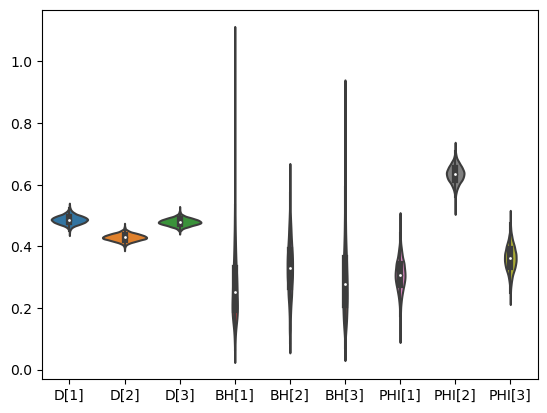

In [41]:
#calculate q values (i.e posterior probability of difference with control being greater than 0)
drugs_draw_pd=fit3.draws_pd()
draws_trunc_columns=drugs_draw_pd.iloc[:,drugs_draw_pd.columns.isin(["BH[1]", "BH[2]", "BH[3]", "D[1]", "D[2]", "D[3]", "PHI[1]", "PHI[2]", "PHI[3]"])]
draws_trunc_columns
sns.violinplot(data=draws_trunc_columns)

## Q values

In [80]:
#calculate q values (i.e posterior probability of difference with control being greater than 0)
#create a matrix of pairwise differences between D[1] and [D2]
#calculate the proportion of differences that are greater than 0
#this is the q value
#repeat for BH and PHI
#this is the q value
def calculateqvalue(draws_trunc_columns, varname, column1_index, column2_index):
  d1_repmat=np.expand_dims(draws_trunc_columns[varname+"["+str(column1_index)+"]"].to_numpy(), axis=1).repeat(len(draws_trunc_columns[varname+"["+str(column2_index)+"]"]),axis=1)
  d2_repmat=np.expand_dims(draws_trunc_columns[varname+"["+str(column2_index)+"]"].to_numpy(), axis=1).repeat(len(draws_trunc_columns[varname+"["+str(column1_index)+"]"]),axis=1)
  q_ind=np.min([1-np.sum((d1_repmat-d2_repmat.T)>0)/(len(draws_trunc_columns[varname+"["+str(column2_index)+"]"])**2), np.sum((d1_repmat-d2_repmat.T)>0)/(len(draws_trunc_columns[varname+"["+str(column2_index)+"]"])**2)])
  q=(draws_trunc_columns[varname+"["+str(column1_index)+"]"].to_numpy()-draws_trunc_columns[varname+"["+str(column2_index)+"]"].to_numpy()>0).sum()/len(draws_trunc_columns[varname+"["+str(column2_index)+"]"])
  q=np.min([q, 1-q])
  print("q value for "+varname+"["+str(column1_index)+"] and "+varname+"["+str(column2_index)+"] is "+str(q)+"("+str(q_ind) +" assuming independence)")
  return q

calculateqvalue(draws_trunc_columns, "D", 1, 2)
calculateqvalue(draws_trunc_columns, "D", 1, 3)
calculateqvalue(draws_trunc_columns, "D", 2, 3)
calculateqvalue(draws_trunc_columns, "BH", 1, 2)
calculateqvalue(draws_trunc_columns, "BH", 1, 3)
calculateqvalue(draws_trunc_columns, "BH", 2, 3)
calculateqvalue(draws_trunc_columns, "PHI", 1, 2)
calculateqvalue(draws_trunc_columns, "PHI", 1, 3)
calculateqvalue(draws_trunc_columns, "PHI", 2, 3)


q value for D[1] and D[2] is 0.00012500000000004174(0.00038264062500004137 assuming independence)
q value for D[1] and D[3] is 0.34075(0.33537253125 assuming independence)
q value for D[2] and D[3] is 0.00025(0.0006601875 assuming independence)
q value for BH[1] and BH[2] is 0.32325(0.323770734375 assuming independence)
q value for BH[1] and BH[3] is 0.43575(0.43938509375 assuming independence)
q value for BH[2] and BH[3] is 0.39312499999999995(0.38966807812500004 assuming independence)
q value for PHI[1] and PHI[2] is 0.0(0.0 assuming independence)
q value for PHI[1] and PHI[3] is 0.1975(0.200752546875 assuming independence)
q value for PHI[2] and PHI[3] is 0.0(0.0 assuming independence)


0.0

# Serotonin Mutants

In [63]:
serotonin_mutants

,Unnamed: 0,Batch #,Fly ID,Date,Day,Drug Treatment,nTurns,rBias,uID,x
0,0,4,1,5/4,1,TrH,466,0.526882,20,246
1,1,4,2,5/4,1,TrH,500,0.442886,42,221
2,2,4,3,5/4,1,TrH,567,0.556537,64,316
3,3,4,4,5/4,1,TrH,526,0.565714,86,298
4,4,4,5,5/4,1,TrH,370,0.696477,108,258
...,...,...,...,...,...,...,...,...,...,...
1723,1723,4,92,5/20,17,control,-1,NaN,181,0
1724,1724,4,93,5/20,17,control,-1,NaN,183,0
1725,1725,4,94,5/20,17,control,-1,NaN,185,0
1726,1726,4,95,5/20,17,control,-1,NaN,187,0


In [64]:
mutant_stan_dict

{'N': 192,
 'S': 2,
 'T': 18,
 's': array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2], dtype=int8),
 'fly_i_obs': 0        21
 1        43
 2        65
 3        87
 4       109
        ... 
 1714    162
 1716    166
 1718    170
 1719    172
 1721    178
 Name: uID, Length: 1293, dtype: int16,
 'time_i_obs': array([ 2,  2,  2, ..., 18, 18, 18]),
 't_obs': 1293,
 'x_obs': array([246, 221, 316, ...,  

In [65]:
fit_mutant = model3.sample(data=mutant_stan_dict,
#  show_console=True,
#  adapt_delta=0.999,
 
  iter_sampling=2000)

16:28:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:28:53 - cmdstanpy - INFO - CmdStan done processing.
16:28:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmpnejj9hgt.stan', line 74, column 8 to column 34)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmpnejj9hgt.stan', line 74, column 8 to column 34)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmpnejj9hgt.stan', line 78, column 10 to column 51)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmpnejj9hgt.stan', line 74, column 8 to column 34)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s_/7_g1r1fs2wdcxn113q39_gzw0000gn/T/tmp7r9smqxq/tmp